# Gemicai tutorial 5: Advanced ClassifierTree
In this tutorial we'll go a bit more in depth about what the ClassifierTree can do.

In [1]:
import gemicai as gem
import torch
import torchvision.models as models

## 5.1 Recap
In the previous tutorial, we have learned about the concept and core functionality of ClassifierTree, in this tutorial, we'll go more in depth on how to actually make it work. But first, a quick recap of everything we need from tutorial 4.

### Load tree
In this example we'll be taking a look at the ClassifierTree that determines the StudyDescription for images from the DX modality.

In [2]:
tree_path = '/mnt/SharedStor/trees/dx_tree'

tree = gem.ClassifierTree.from_dir(tree_path)

print(tree)

|   Depth | Label            |   Classifiers |   Avg. classes |
|---------+------------------+---------------+----------------|
|       0 | BodyPartExamined |             1 |           19   |
|       1 | StudyDescription |            20 |            9.2 |



### Initialize gemsets
To train and evaluate a tree, we first need to create a training- and test-dataset

In [3]:
relevant_labels = ['BodyPartExamined', 'StudyDescription']

train_path = '/mnt/SharedStor/gemset/DX/train'
test_path = '/mnt/SharedStor/gemset/DX/test'

trainset = gem.DicomoDataset.get_dicomo_dataset(train_path, relevant_labels)
testset = gem.DicomoDataset.get_dicomo_dataset(test_path, relevant_labels)

### Evaluate tree
With this evaluation we can inspect the performance of individual nodes.

In [4]:
tree.evaluate(testset)

|  Node | Depth | Parents              |  Classes |  Test size |   Test acc | 
|-------+-------+----------------------+----------+------------+------------|
|     1 |     0 | .                    |       21 |       1904 |     91.65% | 
|     2 |     1 | FOOT                 |       12 |        192 |     81.25% | 
|     3 |     1 | PELVIS               |       13 |        102 |      59.8% | 
|     4 |     1 | SKULL                |        2 |          8 |      87.5% | 
|     5 |     1 | SHOULDER             |       16 |        135 |     61.48% | 
|     6 |     1 | TSPINE               |        3 |         19 |     84.21% | 
|     7 |     1 | CSPINE               |        1 |         30 |     100.0% | 
|     8 |     1 | CLAVICLE             |        5 |          5 |     100.0% | 
|     9 |     1 | SSPINE               |        1 |          0 |       N/A% | 
|    10 |     1 | ARM                  |        4 |          2 |     100.0% | 
|    11 |     1 | ANKLE                |       10 |  

## 5.2 Tweaking individual nodes in the tree
To get the best overall performance for a ClassifierTree, it is important that all nodes function accurately. From the evaluation we can see that node 3, (the one that classifies the StudyDescription of Pelvis images) appears to not be performing very well. To train this individual node, we first need to find it's path

In [5]:
# By default the filename of the node is <node.label>.gemnode
node_path = '/mnt/SharedStor/trees/dx_tree/PELVIS/StudyDescription.gemnode'

node = gem.ClassifierNode.from_file(node_path)

# Select neural network from the node
net = node.classifier

# As you can see, node.classifier is an instance of Gemicai.Classifier
print(type(net))

# The classifiers' classes
print(net.classes)

<class 'gemicai.Classifier.Classifier'>
['Bekken', 'Femur rechts', 'Bekken+heup links', 'Bekken+heup rechts', 'Coccygis', 'Heup rechts', 'Bekken+heup beiderzijds', 'Heup links', 'Bekken kind', 'Heupen baby', 'Sacrum', 'Heup beiderzijds kind', 'Bekken+heup beiderzijds kind']


As you can see, net is an instance of Gemicai.Classifier, we already know how to train a Classifier! For more information about Gemicai.Classifier see tutorial 2. 

### Create train- and test-subset
To train an individual node in the tree, first create subsets that only contain data relevant for that specific node. 

In [6]:
constraints = {
    'BodyPartExamined': 'PELVIS'
}

label = 'StudyDescription'

trainsubset = trainset.subset(constraints)[label]
testsubset = testset.subset(constraints)[label]

trainsubset.summarize(label)
testsubset.summarize(label)

| Class (StudyDescription)     |   Frequency |
|------------------------------+-------------|
| Bekken+heup links            |         112 |
| Bekken                       |          86 |
| Bekken+heup beiderzijds      |          33 |
| Bekken+heup rechts           |          92 |
| Bekken kind                  |           8 |
| Heupen baby                  |           9 |
| Heup rechts                  |           1 |
| Coccygis                     |           7 |
| Sacrum                       |           1 |
| Bekken+heup beiderzijds kind |           1 |
| Femur rechts                 |           1 |
| Heup links                   |           1 |
| Heup beiderzijds kind        |           1 |
| Femur links                  |           1 |

Total number of training images: 354 
Total number of classes: 14

| Class (StudyDescription)   |   Frequency |
|----------------------------+-------------|
| Bekken                     |          28 |
| Bekken+heup rechts         |          30 |


### Train existing node
Now that we've constructed a training subset and a testsubset, we can train the node.

In [7]:
# Verbosity=1 means no train acc or test acc will be calculated after every epoch. This reduces training time.
net.train(trainsubset, epochs=5, verbosity=1)

# Verbosity=2 means train acc will be calcuated after every epoch. (And also for a test set if passed as argument)
net.train(trainsubset, test_dataset=testsubset, epochs=5, verbosity=2)


| Epoch | Avg. loss | Train Acc. | Test Acc.  | Elapsed  |   ETA    |
|-------+-----------+------------+------------+----------+----------|
|     1 | 0.0185672 | -          | -          | 00:00:08 | 18:40:16 |
|     2 | 0.0074461 | -          | -          | 00:00:08 | 18:40:16 |
|     3 | 0.0084622 | -          | -          | 00:00:08 | 18:40:16 |
|     4 | 0.0058611 | -          | -          | 00:00:08 | 18:40:16 |
|     5 | 0.0030107 | -          | -          | 00:00:08 | 18:40:16 |
Training finished, total time elapsed: 0:00:44.239242

| Epoch | Avg. loss | Train Acc. | Test Acc.  | Elapsed  |   ETA    |
|-------+-----------+------------+------------+----------+----------|
|     1 | 0.0016090 | 81.14%     | 55.88%     | 00:00:20 | 18:42:10 |
|     2 | 0.1640995 | 64.86%     | 58.82%     | 00:00:20 | 18:42:10 |
|     3 | 0.0858445 | 86.86%     | 66.67%     | 00:00:20 | 18:42:10 |
|     4 | 0.0515062 | 77.71%     | 62.75%     | 00:00:20 | 18:42:10 |
|     5 | 0.0378983 | 84.29%     | 

### Re-evaluate node

In [8]:
net.evaluate(testsubset, verbosity=2)

| <class 'list'> | <class 'list'> | <class 'list'> |
| Class                        |   Total |   Correct | Acc    |
|------------------------------+---------+-----------+--------|
| Bekken                       |      28 |        24 | 85.7%  |
| Femur rechts                 |       0 |         0 | -      |
| Bekken+heup links            |      28 |        17 | 60.7%  |
| Bekken+heup rechts           |      30 |        23 | 76.7%  |
| Coccygis                     |       0 |         0 | -      |
| Heup rechts                  |       0 |         0 | -      |
| Bekken+heup beiderzijds      |      11 |         5 | 45.5%  |
| Heup links                   |       0 |         0 | -      |
| Bekken kind                  |       2 |         1 | 50.0%  |
| Heupen baby                  |       2 |         2 | 100.0% |
| Sacrum                       |       1 |         0 | 0.0%   |
| Heup beiderzijds kind        |       0 |         0 | -      |
| Bekken+heup beiderzijds kind |       0 |         

(70.59, 102, 72)

Once we're satisfied with the nodes performance, all we have to do is save it. We can then re-evaluate the tree and see that the accuracy of node 3 indeed has increased!

In [9]:
node.save()

tree.evaluate(testset)

|  Node | Depth | Parents              |  Classes |  Test size |   Test acc | 
|-------+-------+----------------------+----------+------------+------------|
|     1 |     0 | .                    |       21 |       1904 |     91.65% | 
|     2 |     1 | FOOT                 |       12 |        192 |     81.25% | 
|     3 |     1 | PELVIS               |       13 |        102 |     70.59% | 
|     4 |     1 | SKULL                |        2 |          8 |      87.5% | 
|     5 |     1 | SHOULDER             |       16 |        135 |     61.48% | 
|     6 |     1 | TSPINE               |        3 |         19 |     84.21% | 
|     7 |     1 | CSPINE               |        1 |         30 |     100.0% | 
|     8 |     1 | CLAVICLE             |        5 |          5 |     100.0% | 
|     9 |     1 | SSPINE               |        1 |          0 |       N/A% | 
|    10 |     1 | ARM                  |        4 |          2 |     100.0% | 
|    11 |     1 | ANKLE                |       10 |  

## 5.3 Additional techniques for improved performance

### Class selection
If the classifier is still not up to the desired performance, try reconsidering the selected classes. Sometimes classes can have to much overlap with others, which makes it difficult for the AI to recognize, but also has less significance to classify in the first place. To illustrate this point, lets plot a confusion matrix for node 1.

| <class 'list'> | <class 'list'> | <class 'list'> |
| Class            |   Total |   Correct | Acc    |
|------------------+---------+-----------+--------|
| VERTEBRAL COLUMN |      89 |        76 | 85.4%  |
| CHEST            |     479 |       471 | 98.3%  |
| KNEE             |     247 |       239 | 96.8%  |
| EXTREMITY        |     167 |       124 | 74.3%  |
| PELVIS           |     102 |        98 | 96.1%  |
| TSPINE           |      19 |        13 | 68.4%  |
| FOOT             |     223 |       211 | 94.6%  |
| SHOULDER         |     139 |       133 | 95.7%  |
| LSPINE           |      51 |        46 | 90.2%  |
| ELBOW            |     121 |       107 | 88.4%  |
| HIP              |     101 |        92 | 91.1%  |
| CSPINE           |      30 |        26 | 86.7%  |
| ANKLE            |      26 |        20 | 76.9%  |
| HAND             |      67 |        53 | 79.1%  |
| CLAVICLE         |       5 |         4 | 80.0%  |
| ABDOMEN          |      19 |        15 | 78.9%  |
| SKULL    

(91.65, 1904, 1745)

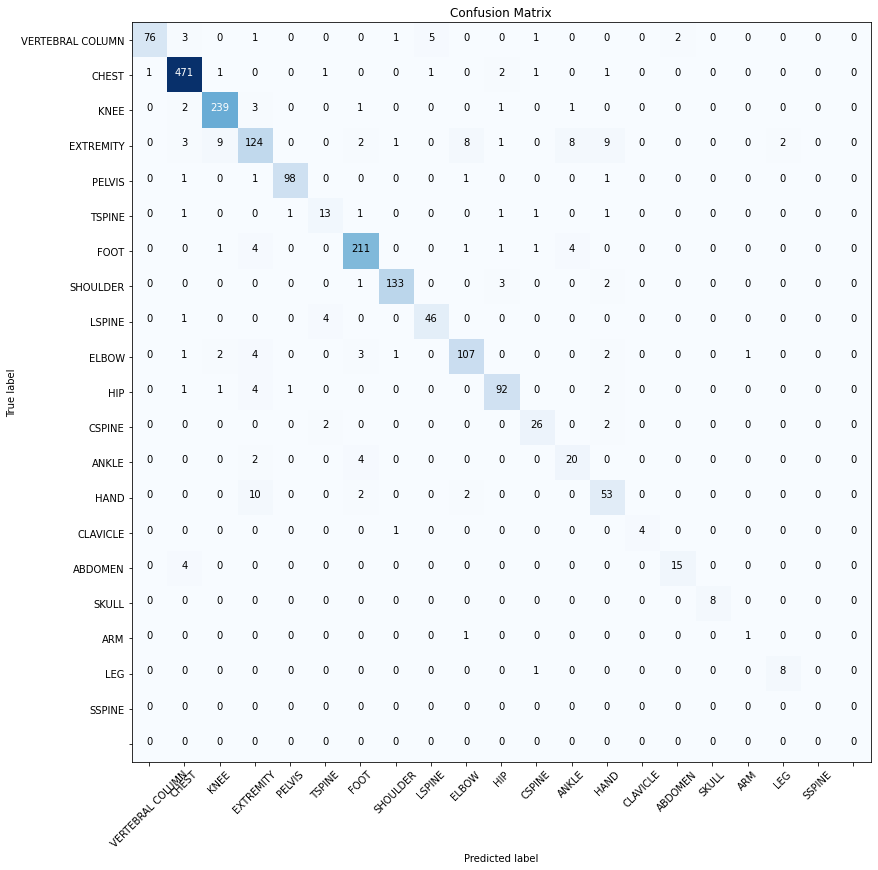

In [10]:
# Node 1 is the root of the DX tree
node = tree.root

# Label is an attribute of node, and in this case label == "BodyPartExamined"
label = node.label

# Set plot_cm=True to plot a confusion matrix
node.classifier.evaluate(testset[label], verbosity=2, plot_cm=True)

From the confusion matrix we can see that the classifier struggles with the class "EXTREMITY" and often incorrectly classifies it as "KNEE", "ELBOW", "ANKLE" or "HAND". The aformentioned classes also have "EXTREMITY" as their most common misclassification. What is going on here? To further investigate, we make a summary of the StudyDescription of all images with BodyPartExamined == "EXTREMITY"

In [11]:
trainset.subset({label: 'EXTREMITY'}).summarize('StudyDescription')

| Class (StudyDescription)       |   Frequency |
|--------------------------------+-------------|
| Vinger rechts                  |          78 |
| Hand rechts                    |          88 |
| Enkel rechts                   |           5 |
| Humerus links                  |           4 |
| Hand links                     |          53 |
| Lengteprognose handwortel      |           3 |
| Onderbeen rechts               |          31 |
| Vinger links                   |          95 |
| Hand beiderzijds               |          64 |
| Onderbeen links                |          37 |
| Femur rechts                   |          21 |
| Pols links                     |           2 |
| Femur links                    |          13 |
| Onderarm links                 |           8 |
| Onderarm rechts                |          12 |
| Humerus rechts                 |           5 |
| Enkel links                    |           4 |
| Schouder links                 |           1 |
| Lengteprognose han

From this summary it appears the EXTREMITY class has overlap with muliple other classes. E.g. "Vinger rechts" is also a class of the node 17 (where BodyPartExamined == "HAND").

This means the class "EXTREMITY" appears to have no added value, and should therefore not be classified. When making changes to the classes of the node (or other changes that have impact on the classifiers architecture) you should assign a new classifier to the node. However, let's first create a list of classes you want to classify, and new training- and test-datasets that only contain the wanted classes.

In [12]:
classes = node.classifier.classes.copy()

# Remove unwanted classes
classes.remove('EXTREMITY')
classes.remove('')

constraints = {label: classes}

trainsubset = trainset.subset(constraints)[label]
testsubset = testset.subset(constraints)[label]

# When doing this, the removed classes will be automatically excluded from evaluation and training data
node.dataset_constraints = constraints

### Assign new Classifier to Node
If you want, you can assign a whole new classifier to the node. First train the new and improved Classifier, then assign it to the node's classifier, then save the node. In this example we'll create a new classifier for node 1.

In [13]:
resnet18 = models.resnet18(pretrained=False)

newnet = gem.Classifier(resnet18, classes, enable_cuda=True)

In [14]:
newnet.train(trainsubset, test_dataset=testsubset, epochs=30, verbosity=2)

newnet.evaluate(testsubset, verbosity=2)

| Epoch | Avg. loss | Train Acc. | Test Acc.  | Elapsed  |   ETA    |
|-------+-----------+------------+------------+----------+----------|
|     1 | 0.2316816 | 72.39%     | 69.72%     | 00:01:08 | 03:26:51 |
|     2 | 0.1568038 | 66.22%     | 63.96%     | 00:01:03 | 03:24:11 |
|     3 | 0.1017881 | 76.68%     | 73.63%     | 00:01:03 | 03:24:12 |
|     4 | 0.0744112 | 87.1%      | 84.4%      | 00:01:03 | 03:24:09 |
|     5 | 0.0563215 | 85.16%     | 83.25%     | 00:01:03 | 03:24:08 |
|     6 | 0.0435241 | 84.56%     | 83.65%     | 00:01:02 | 03:24:05 |
|     7 | 0.0347510 | 93.96%     | 90.16%     | 00:01:03 | 03:24:19 |
|     8 | 0.0285379 | 92.9%      | 89.29%     | 00:01:03 | 03:24:20 |
|     9 | 0.0262555 | 95.34%     | 92.0%      | 00:01:03 | 03:24:13 |
|    10 | 0.0196338 | 96.64%     | 92.0%      | 00:01:03 | 03:24:10 |
|    11 | 0.0152638 | 97.37%     | 92.17%     | 00:01:02 | 03:24:02 |
|    12 | 0.0123829 | 97.59%     | 93.09%     | 00:01:02 | 03:24:07 |
|    13 | 0.0095992 

(94.65, 1737, 1644)

Once we are satisfied the with networks performance, we can write it back to the node and save it.

In [15]:
node.classifier = newnet

node.save()

Now, when re-evaluating the tree, we can see that the accuracy of node 1 increased from 91.65% to 94.65%!

In [16]:
tree.evaluate(testset)

|  Node | Depth | Parents              |  Classes |  Test size |   Test acc | 
|-------+-------+----------------------+----------+------------+------------|
|     1 |     0 | .                    |       19 |       1737 |     94.65% | 
|     2 |     1 | FOOT                 |       12 |        192 |     81.25% | 
|     3 |     1 | PELVIS               |       13 |        102 |     70.59% | 
|     4 |     1 | SKULL                |        2 |          8 |      87.5% | 
|     5 |     1 | SHOULDER             |       16 |        135 |     61.48% | 
|     6 |     1 | TSPINE               |        3 |         19 |     84.21% | 
|     7 |     1 | CSPINE               |        1 |         30 |     100.0% | 
|     8 |     1 | CLAVICLE             |        5 |          5 |     100.0% | 
|     9 |     1 | SSPINE               |        1 |          0 |       N/A% | 
|    10 |     1 | ARM                  |        4 |          2 |     100.0% | 
|    11 |     1 | ANKLE                |       10 |  

### Different models
The classifiers of the nodes in the current tree are all based on ResNet18, which is a relatively lightweight classifier. If you can't seem to get good enough results with ResNet18, you can always try another (deeper) model, e.g. ResNext50.

In [17]:
resnext50 = models.resnext50_32x4d(pretrained=False)

net1 = gem.Classifier(resnext50, classes, enable_cuda=True)

net1.train(trainsubset, test_dataset=testsubset, epochs=30, verbosity=2)

net1.evaluate(testsubset, verbosity=2)

| Epoch | Avg. loss | Train Acc. | Test Acc.  | Elapsed  |   ETA    |
|-------+-----------+------------+------------+----------+----------|
|     1 | 0.3084344 | 39.78%     | 39.55%     | 00:02:38 | 04:46:02 |
|     2 | 0.1883040 | 52.19%     | 50.37%     | 00:02:34 | 04:44:20 |
|     3 | 0.1243360 | 73.38%     | 71.1%      | 00:02:34 | 04:44:20 |
|     4 | 0.0987326 | 76.06%     | 73.34%     | 00:02:34 | 04:44:20 |
|     5 | 0.0814267 | 78.88%     | 75.99%     | 00:02:34 | 04:44:21 |
|     6 | 0.0681071 | 80.17%     | 77.09%     | 00:02:35 | 04:44:25 |
|     7 | 0.0581189 | 81.87%     | 78.58%     | 00:02:34 | 04:44:15 |
|     8 | 0.0504734 | 83.96%     | 80.25%     | 00:02:34 | 04:44:12 |
|     9 | 0.0444217 | 85.57%     | 81.64%     | 00:02:34 | 04:44:19 |
|    10 | 0.0399481 | 86.87%     | 82.79%     | 00:02:34 | 04:44:20 |
|    11 | 0.0357404 | 88.64%     | 83.94%     | 00:02:40 | 04:46:15 |
|    12 | 0.0310353 | 88.89%     | 84.17%     | 00:02:42 | 04:46:57 |
|    13 | 0.0268408 

(90.96, 1737, 1580)

### Transfer Learning
You can load the all PyTorch models with pretrained parameters, this can save you a lot of time as you don't have to train your neural network from the ground up!

In [18]:
resnext50_pretrained = models.resnext50_32x4d(pretrained=True)

net2 = gem.Classifier(resnext50_pretrained, classes, enable_cuda=True)

net2.train(trainsubset, test_dataset=testsubset, epochs=30, verbosity=2)

net2.evaluate(testsubset, verbosity=2)

| Epoch | Avg. loss | Train Acc. | Test Acc.  | Elapsed  |   ETA    |
|-------+-----------+------------+------------+----------+----------|
|     1 | 0.1508600 | 88.66%     | 87.74%     | 00:02:38 | 06:04:10 |
|     2 | 0.1498921 | 73.07%     | 72.48%     | 00:02:34 | 06:02:18 |
|     3 | 0.0541149 | 94.61%     | 92.69%     | 00:02:34 | 06:02:23 |
|     4 | 0.0279053 | 93.87%     | 91.94%     | 00:02:34 | 06:02:08 |
|     5 | 0.0249703 | 96.75%     | 95.28%     | 00:02:34 | 06:02:10 |
|     6 | 0.0181177 | 96.19%     | 94.53%     | 00:02:35 | 06:02:22 |
|     7 | 0.0146085 | 97.73%     | 95.45%     | 00:02:35 | 06:02:22 |
|     8 | 0.0117085 | 96.32%     | 94.24%     | 00:02:34 | 06:02:17 |
|     9 | 0.0176489 | 97.56%     | 96.03%     | 00:02:34 | 06:02:14 |
|    10 | 0.0098086 | 98.29%     | 95.97%     | 00:02:34 | 06:02:13 |
|    11 | 0.0093976 | 98.33%     | 95.8%      | 00:02:34 | 06:02:15 |
|    12 | 0.0092595 | 98.53%     | 96.03%     | 00:02:34 | 06:02:10 |
|    13 | 0.0090389 

(96.66, 1737, 1679)

This seems to be the best beforming version so far, with an overal accuracy of 96.66%. The only classes that tend to score lower accuracies are those with limited data avaiaible, simply increasing the size of the dataset should even further improve the classifiers performance.

In [19]:
node.classifier = net2

node.save()